In [2]:
import numpy as np
import matplotlib.pyplot as plt
from graph_tools import Graph
import networkx as nx
import random
import copy
import time
import json

import ldpc
import bposd

from bposd.css_decode_sim import css_decode_sim
from bposd.hgp import hgp
import pickle

import multiprocessing as mp
import random
from ldpc import bp_decoder
from bposd import bposd_decoder
from bposd.css import css_code
from ldpc.codes import ring_code


from scipy.optimize import curve_fit
import stim

import sys
sys.path.append("./src/")
from Decoders import BPOSD_Decoder, FirstMinBPDecoder, BPDecoder
from ErrorPlugin import *
from Simulators import *

# HGP codes

In [3]:
# Load the HGP code - (3,7)
hgp_n225 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n225.pkl')
# hgp_n625 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n625.pkl')
hgp_n625 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n625_q1.pkl')
hgp_n1225 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n1225_q3.pkl')
hgp_n1600 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n1600.pkl')

print('code params1:', hgp_n225.N, hgp_n225.K)
print('code params2:', hgp_n625.N, hgp_n625.K)
print('code params3:', hgp_n1225.N, hgp_n1225.K)
print('code params4:', hgp_n1600.N, hgp_n1600.K)

code params1: 225 17
code params2: 625 25
code params3: 1225 49
code params4: 1600 64


## Data noise

In [4]:
# eval_code_list = [hgp_n225, tanner_code1]
# eval_code_list = [LP_code1, LP_code2, LP_code3]
eval_code_list = [hgp_n225, hgp_n625, hgp_n1225, hgp_n1600]
eval_p_list = 10**(np.linspace(np.log10(5e-2), np.log10(1.3e-1), 4))
eval_wer_list = []

num_runs = 1000
start_time = time.time()
for eval_code in eval_code_list:
    for eval_p in eval_p_list:
        pauli_error_probs = [eval_p/3, eval_p/3, eval_p/3]
        px = (pauli_error_probs[0] + pauli_error_probs[1])
        pz = (pauli_error_probs[1] + pauli_error_probs[2])
        eval_decoder_x = BPOSD_Decoder(h=eval_code.hz, channel_probs=px*np.ones(eval_code.N),
                            max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                            ms_scaling_factor=0.625, osd_method="osd_e",
                            osd_order = 10)
        eval_decoder_z = BPOSD_Decoder(h=eval_code.hx, channel_probs=pz*np.ones(eval_code.N),
                            max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                            ms_scaling_factor=0.625, osd_method="osd_e",
                            osd_order = 10)
        

        code_simulator = CodeSimulator_DataError(code=eval_code, decoder_x=eval_decoder_x, 
                              decoder_z=eval_decoder_z, pauli_error_probs=pauli_error_probs)
        
        eval_wer_list.append(code_simulator.WordErrorRate(num_runs)[0])
        
end_time = time.time()
print('Time elapsed:', end_time - start_time)

eval_wer_array = np.reshape(np.array(eval_wer_list), [len(eval_code_list), len(eval_p_list)])

Time elapsed: 449.65543127059937


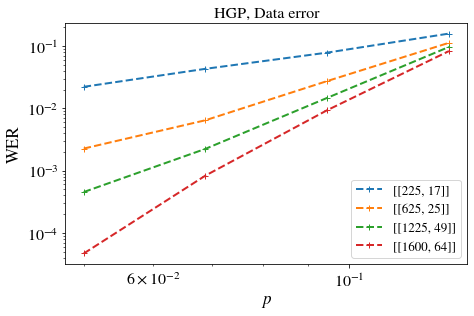

In [6]:
eval_wer_array = np.reshape(np.array(eval_wer_list), [len(eval_code_list), len(eval_p_list)])

plt.figure()
for i in range(len(eval_code_list)):
    plt.plot(eval_p_list, eval_wer_array[i], '+--', label = r'[[%i, %i]]' % (eval_code_list[i].N, eval_code_list[i].K))

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$p$')
plt.ylabel('WER')
plt.title(r'HGP, Data error')
plt.legend()

## Phenomenological noise

In [5]:
# # eval_code_list = [hgp_n625]
# eval_code_list = [LP_code1, LP_code2, LP_code3]
# eval_p_list = 10**(np.linspace(np.log10(1e-2), np.log10(4e-2), 4))
# eval_wer_list = []

# num_rounds = 5
# num_samples = 800
# start_time = time.time()
# for eval_code in eval_code_list:
#     for eval_p in eval_p_list:
#         pauli_error_probs = [eval_p/3, eval_p/3, eval_p/3]

#         eval_hx_extended = np.hstack([eval_code.hx, np.identity(np.shape(eval_code.hx)[0])])
#         eval_hz_extended = np.hstack([eval_code.hz, np.identity(np.shape(eval_code.hz)[0])])

#         dec1_x = FirstMinBPDecoder(h= eval_hz_extended,
#                                    channel_probs=(pauli_error_probs[0] + pauli_error_probs[1])*np.ones(np.shape(eval_hz_extended)[1]),
#                                     max_iter=int(eval_code.N/10), bp_method="minimum_sum",
#                                     ms_scaling_factor=0.625)

#         dec1_z = FirstMinBPDecoder(h=eval_hx_extended,
#                                    channel_probs=(pauli_error_probs[0] + pauli_error_probs[1])*np.ones(np.shape(eval_hx_extended)[1]),
#                                     max_iter=int(eval_code.N/10), bp_method="minimum_sum",
#                                     ms_scaling_factor=0.625)

#         dec2_x = BPOSD_Decoder(h=eval_code.hz, channel_probs=(pauli_error_probs[0] + pauli_error_probs[1])*np.ones(eval_code.N),
#                                     max_iter=int(eval_code.N/10), bp_method="minimum_sum",
#                                     ms_scaling_factor=0.625, osd_method="osd_e",
#                                     osd_order = 10)
#         dec2_z = BPOSD_Decoder(h=eval_code.hx, channel_probs=(pauli_error_probs[1] + pauli_error_probs[2])*np.ones(eval_code.N),
#                                     max_iter=int(eval_code.N/10), bp_method="minimum_sum",
#                                     ms_scaling_factor=0.625, osd_method="osd_e",
#                                     osd_order = 10)

#         code_simulator = CodeSimulator_Phenon(code=eval_code, decoder1_x= dec1_x, decoder1_z= dec1_z,
#                                               decoder2_x=dec2_x, decoder2_z=dec2_z,
#                                               pauli_error_probs=pauli_error_probs)
        
#         eval_wer_list.append(code_simulator.WordErrorRate(num_rounds=num_rounds, num_samples=num_samples)[0])
        
# end_time = time.time()
# print('Time elapsed:', end_time - start_time)

In [40]:
# Load the HGP code - (3,7)
hgp_n225 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n225.pkl')
# hgp_n625 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n625.pkl')
hgp_n625 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n625_q1.pkl')
hgp_n1225 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n1225_q3.pkl')
hgp_n1600 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n1600.pkl')

print('code params1:', hgp_n225.N, hgp_n225.K)
print('code params2:', hgp_n625.N, hgp_n625.K)
print('code params3:', hgp_n1225.N, hgp_n1225.K)
print('code params4:', hgp_n1600.N, hgp_n1600.K)

code params1: 225 17
code params2: 625 25
code params3: 1225 49
code params4: 1600 64


In [49]:
eval_code = hgp_n625

num_samples = 500
sweep_num_cycle_list = np.arange(5,35,5)
eval_p = 1e-2

p = eval_p
p_data = p*2/3
p_synd = p*2/3

pauli_error_probs = [eval_p/3, eval_p/3, eval_p/3] # depolarizing channel [px, py, pyz]

eval_hx_extended = np.hstack([eval_code.hx, np.identity(np.shape(eval_code.hx)[0])])
eval_hz_extended = np.hstack([eval_code.hz, np.identity(np.shape(eval_code.hz)[0])])

# dec1_x = FirstMinBPDecoder(h= eval_hz_extended,
#                                    channel_probs=np.hstack([p_data*np.ones(np.shape(eval_code.hz)[1]), p_synd*np.ones(np.shape(eval_code.hz)[0])]),
#                                     max_iter=int(eval_code.N/10), bp_method="minimum_sum",
#                                     ms_scaling_factor=0.625)

# dec1_z = FirstMinBPDecoder(h=eval_hx_extended,
#                                    channel_probs=np.hstack([p_data*np.ones(np.shape(eval_code.hx)[1]), p_synd*np.ones(np.shape(eval_code.hx)[0])]),
#                                     max_iter=int(eval_code.N/10), bp_method="minimum_sum",
#                                     ms_scaling_factor=0.625)

dec1_x = FirstMinBPDecoder(h= eval_hz_extended,
                                   channel_probs=np.hstack([p_data*np.ones(np.shape(eval_code.hz)[1]), p_synd*np.ones(np.shape(eval_code.hz)[0])]),
                                    max_iter=int(eval_code.N/5), bp_method="minimum_sum",
                                    ms_scaling_factor=0.9)

dec1_z = FirstMinBPDecoder(h=eval_hx_extended,
                                   channel_probs=np.hstack([p_data*np.ones(np.shape(eval_code.hx)[1]), p_synd*np.ones(np.shape(eval_code.hx)[0])]),
                                    max_iter=int(eval_code.N/5), bp_method="minimum_sum",
                                    ms_scaling_factor=0.9)

dec2_x = BPOSD_Decoder(h=eval_code.hz, channel_probs=(pauli_error_probs[0] + pauli_error_probs[1])*np.ones(eval_code.N),
                                    max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                    ms_scaling_factor=0.625, osd_method="osd_e",
                                    osd_order = 10)
dec2_z = BPOSD_Decoder(h=eval_code.hx, channel_probs=(pauli_error_probs[1] + pauli_error_probs[2])*np.ones(eval_code.N),
                                    max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                    ms_scaling_factor=0.625, osd_method="osd_e",
                                    osd_order = 10)

start_time = time.time()
eval_wer_list = []
eval_wer_std_list = []
for sweep_num_cycle in sweep_num_cycle_list:
    code_simulator = CodeSimulator_Phenon(code=eval_code, decoder1_x= dec1_x, decoder1_z= dec1_z,
                                              decoder2_x=dec2_x, decoder2_z=dec2_z,
                                              pauli_error_probs=pauli_error_probs)
    eval_wer, eval_wer_std = code_simulator.WordErrorRate(num_rounds=sweep_num_cycle, num_samples=num_samples)
    eval_wer_list.append(eval_wer)
    eval_wer_std_list.append(eval_wer_std)
end_time = time.time()
print('Time elapsed:', end_time - start_time)


# start_time = time.time()
# eval_wep_list = []
# for sweep_num_cycle in sweep_num_cycle_list:
#     code_simulator = CodeSimulator_Phenon(code=eval_code, decoder1_x= dec1_x, decoder1_z= dec1_z,
#                                               decoder2_x=dec2_x, decoder2_z=dec2_z,
#                                               pauli_error_probs=pauli_error_probs)
#     eval_wep_list.append(code_simulator.WordErrorProbability(num_rounds=sweep_num_cycle, num_samples=num_samples)[0])
# end_time = time.time()
# print('Time elapsed:', end_time - start_time)

Time elapsed: 450.73539304733276


(0.001, 0.003)

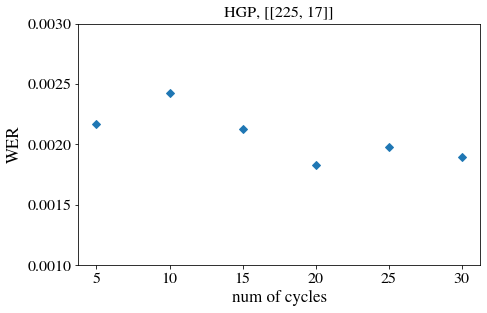

In [48]:
fig, ax = plt.subplots()
# ax.errorbar(sweep_num_cycle_list, eval_wer_list, yerr=np.array(eval_wer_std_list)*1, fmt='.', capsize=3, color = 'C0')
# ax.errorbar(sweep_num_cycle_list, eval_wer_list, yerr=np.array(eval_wer_list)*0, fmt='.', capsize=3, color = 'C0')
ax.plot(sweep_num_cycle_list, eval_wer_list, 'D')
ax.set_xlabel(r'num of cycles')
ax.set_ylabel(r'WER')
plt.title('HGP, ' + r'[[%i, %i]]' % (eval_code.N, eval_code.K))
ax.set_ylim([0.001, 0.003])

Text(0.5, 1.0, 'HGP, [[625, 25]]')

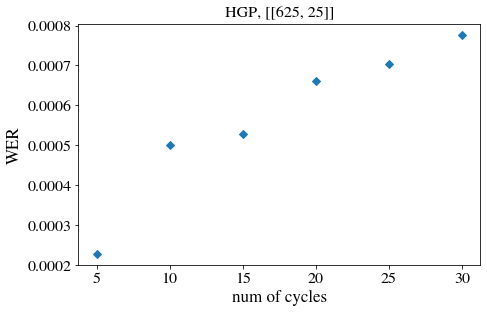

In [42]:
fig, ax = plt.subplots()
# ax.errorbar(sweep_num_cycle_list, eval_wer_list, yerr=np.array(eval_wer_std_list)*1, fmt='.', capsize=3, color = 'C0')
# ax.errorbar(sweep_num_cycle_list, eval_wer_list, yerr=np.array(eval_wer_list)*0, fmt='.', capsize=3, color = 'C0')
ax.plot(sweep_num_cycle_list, eval_wer_list, 'D')
ax.set_xlabel(r'num of cycles')
ax.set_ylabel(r'WER')
plt.title('HGP, ' + r'[[%i, %i]]' % (eval_code.N, eval_code.K))

In [ ]:
### fig, ax = plt.subplots()
ax.errorbar(sweep_num_cycle_list, eval_wer_list, yerr=np.array(eval_wer_std_list)*1, fmt='.', capsize=3, color = 'C0')
# ax.errorbar(sweep_num_cycle_list, eval_wer_list, yerr=np.array(eval_wer_list)*0, fmt='.', capsize=3, color = 'C0')
ax.set_xlabel(r'num of cycles')
ax.set_ylabel(r'WER')
plt.title('HGP, ' + '')

# LP code

In [27]:
# Load the LP codes - (3,8)
from scipy.io import loadmat
LP_code1_hx = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/LP_Matg8_L16_Dmin12_hx.mat')['LP_Matg8_L16_Dmin12_hx']
LP_code1_hz = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/LP_Matg8_L16_Dmin12_hz.mat')['LP_Matg8_L16_Dmin12_hz']
LP_code2_hx = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/LP_Matg8_L21_Dmin16_hx.mat')['LP_Matg8_L21_Dmin16_hx']
LP_code2_hz = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/LP_Matg8_L21_Dmin16_hz.mat')['LP_Matg8_L21_Dmin16_hz']
LP_code3_hx = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/LP_Matg8_L30_Dmin20_hx.mat')['LP_Matg8_L30_Dmin20_hx']
LP_code3_hz = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/LP_Matg8_L30_Dmin20_hz.mat')['LP_Matg8_L30_Dmin20_hz']

LP_code1 = css_code(hx=LP_code1_hx,hz=LP_code1_hz)
LP_code2 = css_code(hx=LP_code2_hx,hz=LP_code2_hz)
LP_code3 = css_code(hx=LP_code3_hx,hz=LP_code3_hz)

print('code params1:', LP_code1.N, LP_code1.K)
print('code params2:', LP_code2.N, LP_code2.K)
print('code params3:', LP_code3.N, LP_code3.K)

code params1: 544 80
code params2: 714 100
code params3: 1020 136


## Phenomenological noise

In [31]:
eval_code = LP_code1

num_samples = 700
sweep_num_cycle_list = np.arange(5,35,5)
eval_code = LP_code1
eval_p = 1e-2

p = eval_p
p_data = p*2/3
p_synd = p*2/3

pauli_error_probs = [eval_p/3, eval_p/3, eval_p/3]

eval_hx_extended = np.hstack([eval_code.hx, np.identity(np.shape(eval_code.hx)[0])])
eval_hz_extended = np.hstack([eval_code.hz, np.identity(np.shape(eval_code.hz)[0])])

dec1_x = FirstMinBPDecoder(h= eval_hz_extended,
                                   channel_probs=np.hstack([p_data*np.ones(np.shape(eval_code.hz)[1]), p_synd*np.ones(np.shape(eval_code.hz)[0])]),
                                    max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                    ms_scaling_factor=0.625)

dec1_z = FirstMinBPDecoder(h=eval_hx_extended,
                                   channel_probs=np.hstack([p_data*np.ones(np.shape(eval_code.hx)[1]), p_synd*np.ones(np.shape(eval_code.hx)[0])]),
                                    max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                    ms_scaling_factor=0.625)

dec2_x = BPOSD_Decoder(h=eval_code.hz, channel_probs=(pauli_error_probs[0] + pauli_error_probs[1])*np.ones(eval_code.N),
                                    max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                    ms_scaling_factor=0.625, osd_method="osd_e",
                                    osd_order = 10)
dec2_z = BPOSD_Decoder(h=eval_code.hx, channel_probs=(pauli_error_probs[1] + pauli_error_probs[2])*np.ones(eval_code.N),
                                    max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                    ms_scaling_factor=0.625, osd_method="osd_e",
                                    osd_order = 10)

start_time = time.time()
eval_wer_list = []
eval_wer_std_list = []
for sweep_num_cycle in sweep_num_cycle_list:
    code_simulator = CodeSimulator_Phenon(code=eval_code, decoder1_x= dec1_x, decoder1_z= dec1_z,
                                              decoder2_x=dec2_x, decoder2_z=dec2_z,
                                              pauli_error_probs=pauli_error_probs)
    eval_wer, eval_wer_std = code_simulator.WordErrorRate(num_rounds=sweep_num_cycle, num_samples=num_samples)
    eval_wer_list.append(eval_wer)
    eval_wer_std_list.append(eval_wer_std)
end_time = time.time()
print('Time elapsed:', end_time - start_time)


# start_time = time.time()
# eval_wep_list = []
# for sweep_num_cycle in sweep_num_cycle_list:
#     code_simulator = CodeSimulator_Phenon(code=eval_code, decoder1_x= dec1_x, decoder1_z= dec1_z,
#                                               decoder2_x=dec2_x, decoder2_z=dec2_z,
#                                               pauli_error_probs=pauli_error_probs)
#     eval_wep_list.append(code_simulator.WordErrorProbability(num_rounds=sweep_num_cycle, num_samples=num_samples)[0])
# end_time = time.time()
# print('Time elapsed:', end_time - start_time)

Time elapsed: 375.65733194351196


Text(0.5, 1.0, 'Lifted Product, [[544, 80]]')

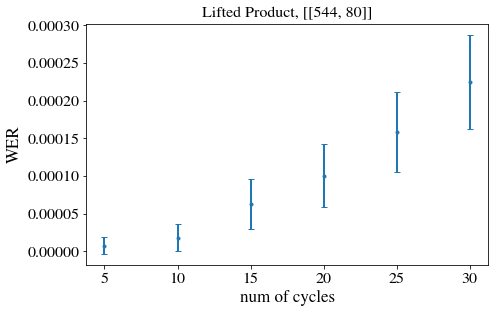

In [32]:
fig, ax = plt.subplots()
ax.errorbar(sweep_num_cycle_list, eval_wer_list, yerr=np.array(eval_wer_std_list)*1, fmt='.', capsize=3, color = 'C0')
# ax.errorbar(sweep_num_cycle_list, eval_wer_list, yerr=np.array(eval_wer_list)*0, fmt='.', capsize=3, color = 'C0')
ax.set_xlabel(r'num of cycles')
ax.set_ylabel(r'WER')
plt.title('Lifted Product, ' + r'[[%i, %i]]' % (eval_code.N, eval_code.K))

# GBC

In [33]:
# Load the generalized bicycle codes (GBC) - (3,6) 
from scipy.io import loadmat
GBC_code1_hx = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/GenBicycleA1_hx.mat')['GenBicycleCodeATh1_hx']
GBC_code1_hz = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/GenBicycleA1_hz.mat')['GenBicycleCodeATh1_hz']
GBC_code2_hx = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/GenBicycleA2_hx.mat')['GenBicycleCodeATh2_hx']
GBC_code2_hz = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/GenBicycleA2_hz.mat')['GenBicycleCodeATh2_hz']
GBC_code3_hx = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/GenBicycleA3_hx.mat')['GenBicycleCodeATh3_hx']
GBC_code3_hz = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/GenBicycleA3_hz.mat')['GenBicycleCodeATh3_hz']

GBC_code1 = css_code(hx=GBC_code1_hx,hz=GBC_code1_hz)
GBC_code2 = css_code(hx=GBC_code2_hx,hz=GBC_code2_hz)
GBC_code3 = css_code(hx=GBC_code3_hx,hz=GBC_code3_hz)

print('code params1:', GBC_code1.N, GBC_code1.K)
print('code params2:', GBC_code2.N, GBC_code2.K)
print('code params3:', GBC_code3.N, GBC_code3.K)

code params1: 126 12
code params2: 254 14
code params3: 510 16


In [36]:
eval_code = LP_code1

num_samples = 600
sweep_num_cycle_list = np.arange(5,35,5)
eval_code = GBC_code1
eval_p = 1e-2

p = eval_p
p_data = p*2/3
p_synd = p*2/3

pauli_error_probs = [eval_p/3, eval_p/3, eval_p/3]

eval_hx_extended = np.hstack([eval_code.hx, np.identity(np.shape(eval_code.hx)[0])])
eval_hz_extended = np.hstack([eval_code.hz, np.identity(np.shape(eval_code.hz)[0])])

dec1_x = FirstMinBPDecoder(h= eval_hz_extended,
                                   channel_probs=np.hstack([p_data*np.ones(np.shape(eval_code.hz)[1]), p_synd*np.ones(np.shape(eval_code.hz)[0])]),
                                    max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                    ms_scaling_factor=0.625)

dec1_z = FirstMinBPDecoder(h=eval_hx_extended,
                                   channel_probs=np.hstack([p_data*np.ones(np.shape(eval_code.hx)[1]), p_synd*np.ones(np.shape(eval_code.hx)[0])]),
                                    max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                    ms_scaling_factor=0.625)

dec2_x = BPOSD_Decoder(h=eval_code.hz, channel_probs=(pauli_error_probs[0] + pauli_error_probs[1])*np.ones(eval_code.N),
                                    max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                    ms_scaling_factor=0.625, osd_method="osd_e",
                                    osd_order = 10)
dec2_z = BPOSD_Decoder(h=eval_code.hx, channel_probs=(pauli_error_probs[1] + pauli_error_probs[2])*np.ones(eval_code.N),
                                    max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                    ms_scaling_factor=0.625, osd_method="osd_e",
                                    osd_order = 10)

start_time = time.time()
eval_wer_list = []
eval_wer_std_list = []
for sweep_num_cycle in sweep_num_cycle_list:
    code_simulator = CodeSimulator_Phenon(code=eval_code, decoder1_x= dec1_x, decoder1_z= dec1_z,
                                              decoder2_x=dec2_x, decoder2_z=dec2_z,
                                              pauli_error_probs=pauli_error_probs)
    eval_wer, eval_wer_std = code_simulator.WordErrorRate(num_rounds=sweep_num_cycle, num_samples=num_samples)
    eval_wer_list.append(eval_wer)
    eval_wer_std_list.append(eval_wer_std)
end_time = time.time()
print('Time elapsed:', end_time - start_time)


# start_time = time.time()
# eval_wep_list = []
# for sweep_num_cycle in sweep_num_cycle_list:
#     code_simulator = CodeSimulator_Phenon(code=eval_code, decoder1_x= dec1_x, decoder1_z= dec1_z,
#                                               decoder2_x=dec2_x, decoder2_z=dec2_z,
#                                               pauli_error_probs=pauli_error_probs)
#     eval_wep_list.append(code_simulator.WordErrorProbability(num_rounds=sweep_num_cycle, num_samples=num_samples)[0])
# end_time = time.time()
# print('Time elapsed:', end_time - start_time)

Time elapsed: 32.65009808540344


Text(0.5, 1.0, 'GBC, [[126, 12]]')

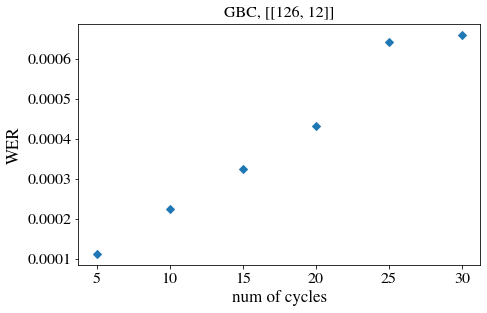

In [38]:
fig, ax = plt.subplots()
# ax.errorbar(sweep_num_cycle_list, eval_wer_list, yerr=np.array(eval_wer_std_list)*1, fmt='.', capsize=3, color = 'C0')
# ax.errorbar(sweep_num_cycle_list, eval_wer_list, yerr=np.array(eval_wer_list)*0, fmt='.', capsize=3, color = 'C0')
ax.plot(sweep_num_cycle_list, eval_wer_list, 'D')
ax.set_xlabel(r'num of cycles')
ax.set_ylabel(r'WER')
plt.title('GBC, ' + r'[[%i, %i]]' % (eval_code.N, eval_code.K))